# RUL Long Live 設備健康檢測作業（解答）

本 Notebook 主要針對設備剩餘壽命（RUL, Remaining Useful Life）進行 long live 測試與分析。內容包含感測數據的讀取、視覺化，以及針對特定設備的數據趨勢觀察，為後續預測與健康管理提供基礎。

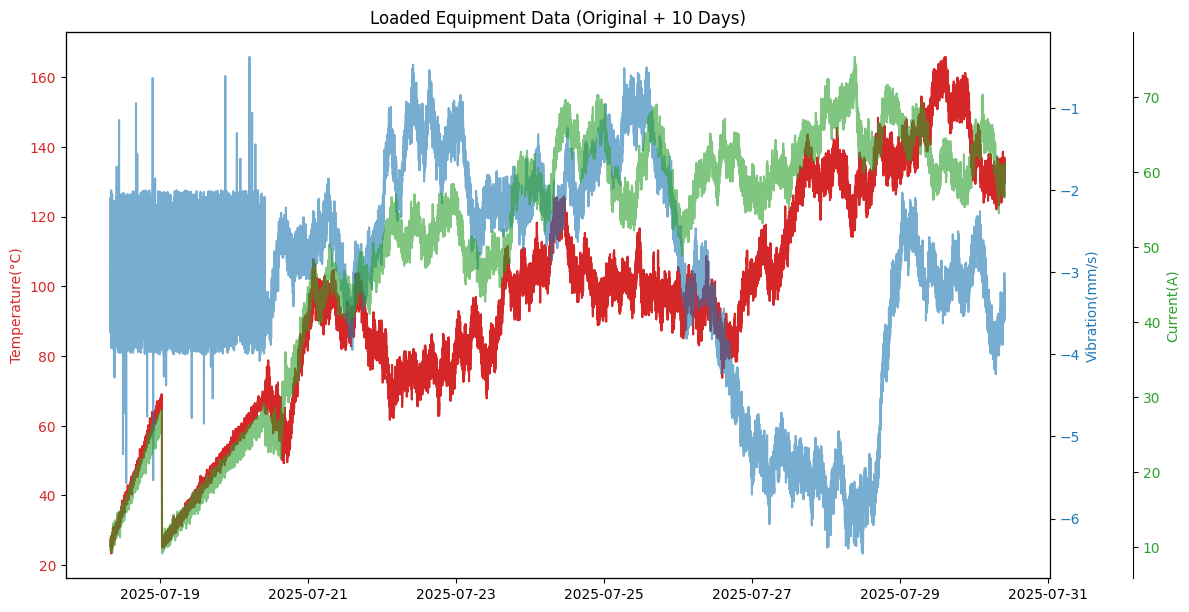

In [2]:
# 匯入必要套件
import pandas as pd  # 資料處理
import numpy as np   # 數值運算
from datetime import datetime, timedelta  # 處理時間
import random
import matplotlib.pyplot as plt
# 讀取完整數據
df_loaded = pd.read_csv('data/equipment_data_with_11days.csv', parse_dates=['Time'])

# 繪製三感測數據折線圖
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_loaded['Time'], df_loaded['Temperature(°C)'], label='Temperature(°C)', color='tab:red')
ax1.set_ylabel('Temperature(°C)', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(df_loaded['Time'], df_loaded['Vibration(mm/s)'], label='Vibration(mm/s)', color='tab:blue', alpha=0.6)
ax2.set_ylabel('Vibration(mm/s)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(df_loaded['Time'], df_loaded['Current(A)'], label='Current(A)', color='tab:green', alpha=0.6)
ax3.set_ylabel('Current(A)', color='tab:green')
ax3.tick_params(axis='y', labelcolor='tab:green')

fig.tight_layout()
plt.title('Loaded Equipment Data (Original + 10 Days)')
plt.show()

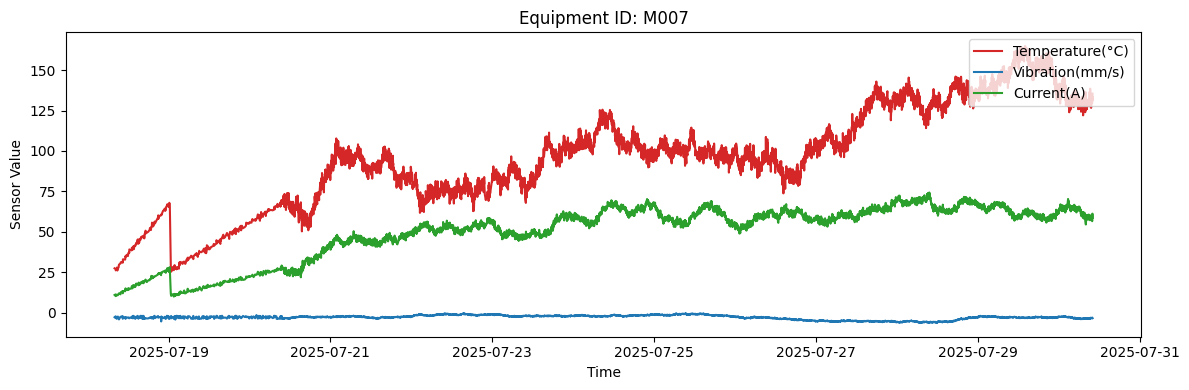

In [3]:
# 只繪製設備編號為 M007 的三感測數據折線圖
sub_df = df_loaded[df_loaded['Equipment_ID'] == 'M007']
plt.figure(figsize=(12, 4))
plt.plot(sub_df['Time'], sub_df['Temperature(°C)'], label='Temperature(°C)', color='tab:red')
plt.plot(sub_df['Time'], sub_df['Vibration(mm/s)'], label='Vibration(mm/s)', color='tab:blue')
plt.plot(sub_df['Time'], sub_df['Current(A)'], label='Current(A)', color='tab:green')
plt.title('Equipment ID: M007')
plt.ylabel('Sensor Value')
plt.xlabel('Time')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## 步驟1：建立訓練集與預測集

將 sub_df 於 7/19~7/22 的資料作為訓練集，並預測後續的溫度趨勢。

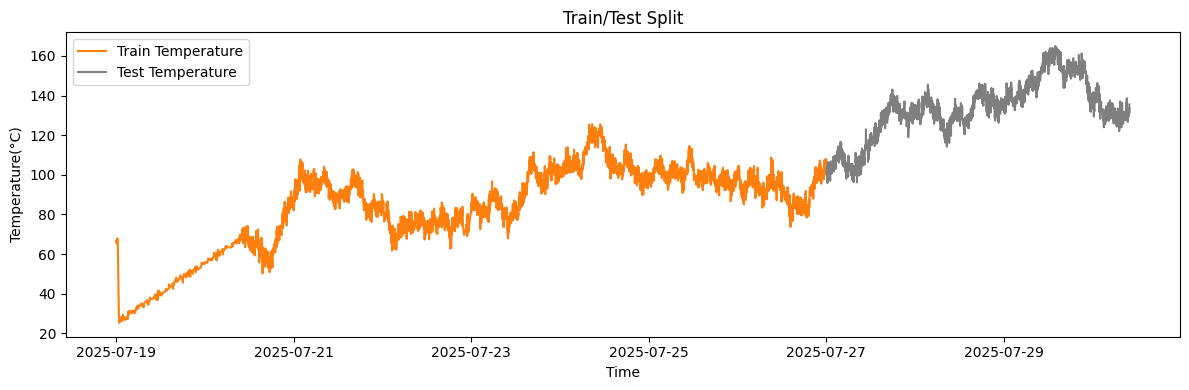

((3289, 6), (1636, 6))

In [30]:
# 依日期分割訓練集與預測集
train_start = '2025-07-19'
train_end = '2025-07-27'

train_df = sub_df[(sub_df['Time'] >= train_start) & (sub_df['Time'] <= train_end)].copy()
test_df = sub_df[sub_df['Time'] > train_end].copy()

plt.figure(figsize=(12, 4))
plt.plot(train_df['Time'], train_df['Temperature(°C)'], label='Train Temperature', color='tab:orange')
plt.plot(test_df['Time'], test_df['Temperature(°C)'], label='Test Temperature', color='tab:gray')
plt.title('Train/Test Split')
plt.ylabel('Temperature(°C)')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()

train_df.shape, test_df.shape

## 步驟2：LSTM模型訓練與預測

利用LSTM模型，根據震動與電流數據來預測溫度趨勢。

In [31]:
# LSTM資料前處理
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:(i + seq_length)])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

features = ['Vibration(mm/s)', 'Current(A)']
target = 'Temperature(°C)'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[[target]])
X_test = scaler_X.transform(test_df[features])
y_test = scaler_y.transform(test_df[[target]])

seq_length = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

((3279, 10, 2), (3279, 1), (1626, 10, 2), (1626, 1))

In [32]:
# 建立與訓練LSTM模型
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LayerNormalization, Dropout

model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    LayerNormalization(),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    LayerNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

# 預測
pred_train = model.predict(X_train_seq)
pred_test = model.predict(X_test_seq)

# 還原標準化
pred_train_inv = scaler_y.inverse_transform(pred_train)
pred_test_inv = scaler_y.inverse_transform(pred_test)
y_train_inv = scaler_y.inverse_transform(y_train_seq)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

Epoch 1/30
164/164 [==============================] - 8s 21ms/step - loss: 0.0271 - val_loss: 0.0125
Epoch 2/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0158 - val_loss: 0.0176
Epoch 3/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0131 - val_loss: 0.0166
Epoch 4/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0131 - val_loss: 0.0236
Epoch 5/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0121 - val_loss: 0.0190
Epoch 6/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 7/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0105 - val_loss: 0.0193
Epoch 8/30
164/164 [==============================] - 3s 17ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 9/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0102 - val_loss: 0.0302
Epoch 10/30
164/164 [==============================] - 3s 16ms/step - loss: 0.0105 - val_lo

## 步驟3：結果評估

以MSE、MAE等指標評估LSTM模型預測效果，並繪製實際與預測溫度趨勢圖。

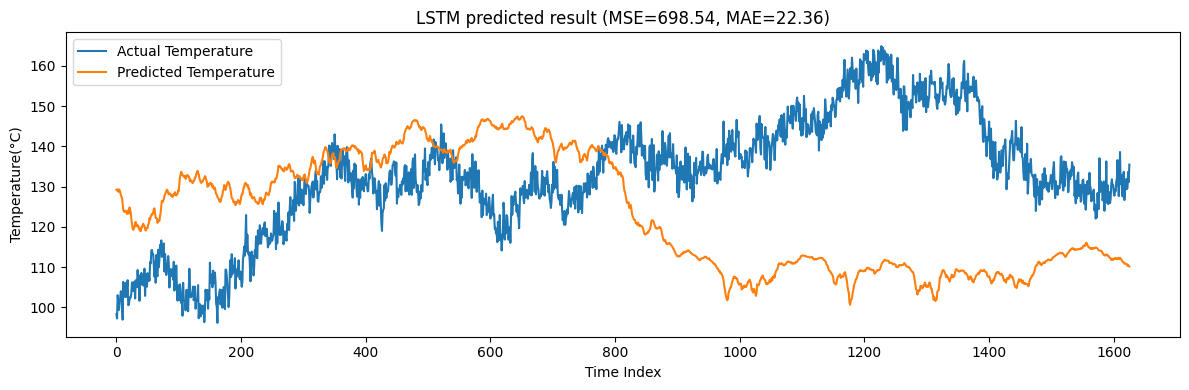

MSE: 698.54, MAE: 22.36


In [33]:
# 評估指標與趨勢圖
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_inv, pred_test_inv)
mae = mean_absolute_error(y_test_inv, pred_test_inv)

plt.figure(figsize=(12, 4))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Actual Temperature', color='tab:blue')
plt.plot(range(len(pred_test_inv)), pred_test_inv, label='Predicted Temperature', color='tab:orange')
plt.title(f'LSTM predicted result (MSE={mse:.2f}, MAE={mae:.2f})')
plt.ylabel('Temperature(°C)')
plt.xlabel('Time Index')
plt.legend()
plt.tight_layout()
plt.show()

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

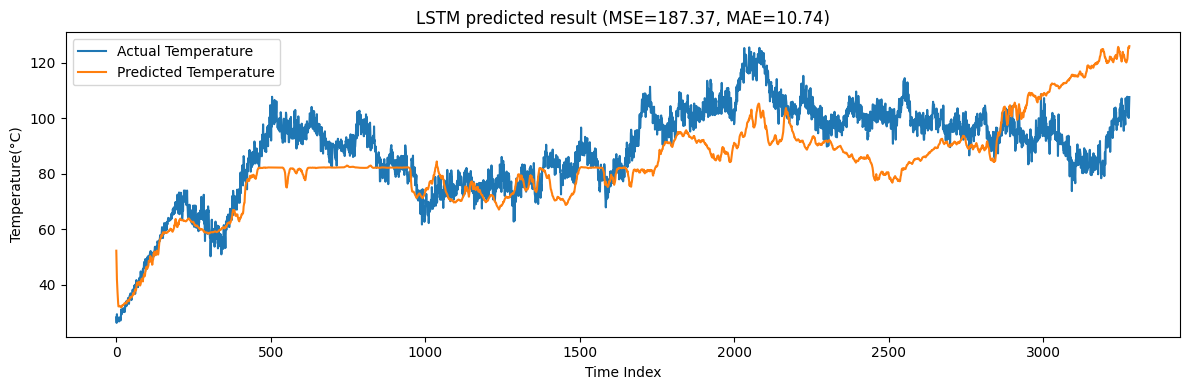

MSE: 187.37, MAE: 10.74


In [34]:
# 評估指標與趨勢圖
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_train_inv, pred_train_inv)
mae = mean_absolute_error(y_train_inv, pred_train_inv)

plt.figure(figsize=(12, 4))
plt.plot(range(len(y_train_inv)), y_train_inv, label='Actual Temperature', color='tab:blue')
plt.plot(range(len(pred_train_inv)), pred_train_inv, label='Predicted Temperature', color='tab:orange')
plt.title(f'LSTM predicted result (MSE={mse:.2f}, MAE={mae:.2f})')
plt.ylabel('Temperature(°C)')
plt.xlabel('Time Index')
plt.legend()
plt.tight_layout()
plt.show()

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

## 步驟4：RUL分析與剩餘壽命顯示

根據預測溫度與實際溫度的差異，計算設備剩餘壽命（RUL），並視覺化RUL變化。

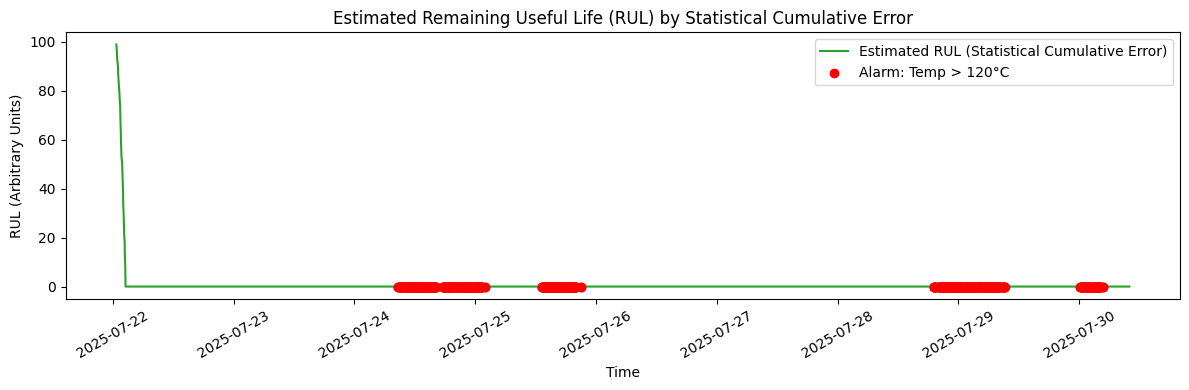

警報：預測溫度超過120°C，首次發生於 2025-07-24 08:37:00
Estimated Remaining Useful Life: 99.0 (起始壽命單位)
Epoch 1/30


198/198 [==============================] - 4s 11ms/step - loss: 0.0315 - val_loss: 0.0132
Epoch 2/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 3/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0119 - val_loss: 0.0127
Epoch 4/30
198/198 [==============================] - 2s 9ms/step - loss: 0.0119 - val_loss: 0.0127
Epoch 5/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0117 - val_loss: 0.0124
Epoch 6/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0117 - val_loss: 0.0122
Epoch 7/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0113 - val_loss: 0.0128
Epoch 8/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 9/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 10/30
198/198 [==============================] - 2s 9ms/step - loss: 0.0112 - val_loss: 0.0132
Epoch 11/

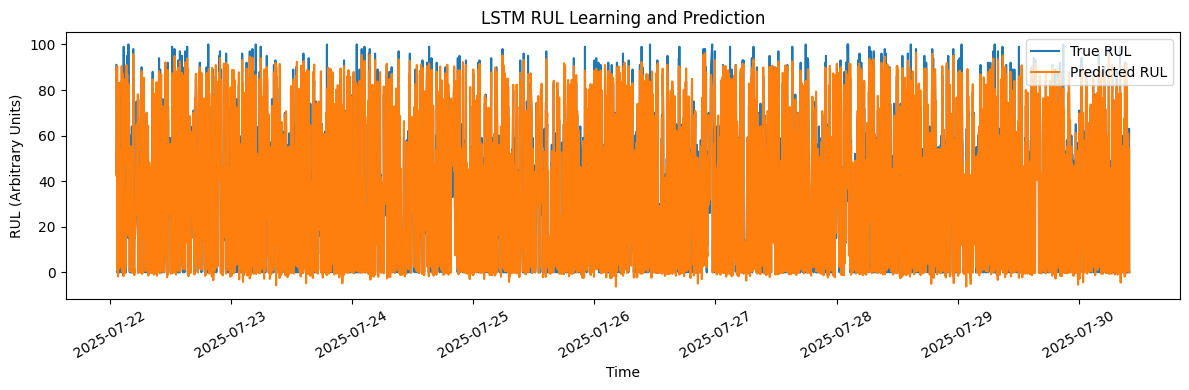

RUL預測 MSE: 24.67, MAE: 3.31


In [48]:
# RUL計算與視覺化（累計統計型，x軸為時間，溫度警報）
threshold = 120  # 溫度警報門檻

# 計算每一點的預測誤差，並進行平滑處理（移動平均）
error = np.abs(y_test_inv.flatten() - pred_test_inv.flatten())
window = 10  # 平滑視窗，可調整
if len(error) > window:
    smooth_error = np.convolve(error, np.ones(window)/window, mode='same')
else:
    smooth_error = error

# 統計型RUL：每超過一個誤差閾值才扣減壽命
error_unit = 10  # 每累積多少誤差才扣減一次壽命
max_rul = 100
cum_error = np.cumsum(smooth_error)
rul = np.clip(max_rul - (cum_error // error_unit), 0, max_rul)

# 取得對應的時間序列
rul_time = test_df['Time'].iloc[seq_length:].reset_index(drop=True)

# 溫度警報標記
alarm_idx = np.where(pred_test_inv.flatten() > threshold)[0]

plt.figure(figsize=(12, 4))
plt.plot(rul_time, rul, label='Estimated RUL (Statistical Cumulative Error)', color='tab:green')
if len(alarm_idx) > 0:
    plt.scatter(rul_time.iloc[alarm_idx], rul[alarm_idx], color='red', label=f'Alarm: Temp > {threshold}°C', zorder=5)
plt.title('Estimated Remaining Useful Life (RUL) by Statistical Cumulative Error')
plt.ylabel('RUL (Arbitrary Units)')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

if len(alarm_idx) > 0:
    print(f"警報：預測溫度超過120°C，首次發生於 {rul_time.iloc[alarm_idx[0]]}")
else:
    print("無溫度超標警報。")

print(f"Estimated Remaining Useful Life: {rul[0]:.1f} (起始壽命單位)")

# 建立RUL序列資料
seq_length_rul = 10
X_rul_seq, y_rul_seq = create_rul_sequences(X_rul_scaled, y_rul_scaled, seq_length_rul)

# --- 新增：訓練前同步隨機打亂 ---
idx = np.arange(len(X_rul_seq))
np.random.seed(42)
np.random.shuffle(idx)
X_rul_seq = X_rul_seq[idx]
y_rul_seq = y_rul_seq[idx]
# ---

# LSTM模型訓練
model_rul = Sequential([
    LSTM(32, input_shape=(X_rul_seq.shape[1], X_rul_seq.shape[2]), return_sequences=False),
    Dense(1)
])
model_rul.compile(optimizer='adam', loss='mse')

history_rul = model_rul.fit(X_rul_seq, y_rul_seq, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

# 預測與還原
pred_rul_scaled = model_rul.predict(X_rul_seq)
pred_rul = scaler_y_rul.inverse_transform(pred_rul_scaled)
true_rul = scaler_y_rul.inverse_transform(y_rul_seq)

# 結果分析與視覺化
plt.figure(figsize=(12, 4))
rul_time_seq = rul_time.iloc[seq_length_rul:].reset_index(drop=True)
plt.plot(rul_time_seq, true_rul, label='True RUL', color='tab:blue')
plt.plot(rul_time_seq, pred_rul, label='Predicted RUL', color='tab:orange')
plt.title('LSTM RUL Learning and Prediction')
plt.ylabel('RUL (Arbitrary Units)')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

mse_rul = mean_squared_error(true_rul, pred_rul)
mae_rul = mean_absolute_error(true_rul, pred_rul)
print(f"RUL預測 MSE: {mse_rul:.2f}, MAE: {mae_rul:.2f}")

RUL在一開始就迅速歸零，這代表累積誤差或警報條件太容易觸發，導致壽命指標瞬間耗盡。這常見原因有：

預測誤差本身很大，或error_unit設太小。
max_rul設太低。
溫度警報門檻過低，導致紅點密集且RUL同步歸零。
累積誤差的統計方式仍過於敏感。
建議調整方式如下：

將error_unit（每累積多少誤差才扣減一次壽命）大幅提高，例如設為50、100甚至更高。
max_rul可設為500或1000，讓壽命消耗更慢。
可考慮只在誤差大於某一閾值時才累加到RUL消耗（即小誤差不計入壽命消耗）。

**更穩健的RUL計算版本**

平滑視窗加大
只累積顯著誤差才消耗壽命
誤差累積單位與最大壽命放大

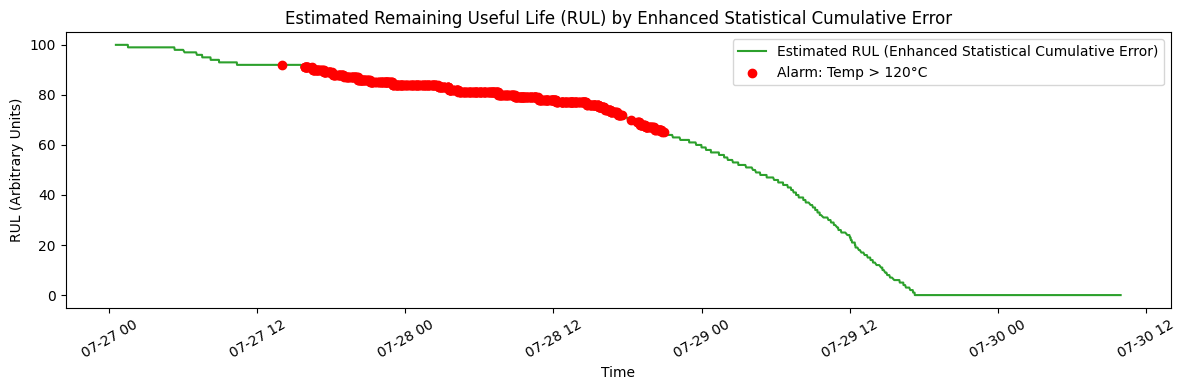

警報：預測溫度超過120°C，首次發生於 2025-07-27 14:00:00
Estimated Remaining Useful Life: 100.0 (起始壽命單位)


In [16]:
# RUL計算與視覺化（多重條件修正，x軸為時間，溫度警報）
threshold = 120  # 溫度警報門檻

# 計算每一點的預測誤差，並進行平滑處理（移動平均）
error = np.abs(y_test_inv.flatten() - pred_test_inv.flatten())
window = 20  # 平滑視窗加大
if len(error) > window:
    smooth_error = np.convolve(error, np.ones(window)/window, mode='same')
else:
    smooth_error = error

# 只累積大於一定誤差的部分才消耗壽命
error_threshold = 5  # 小於此誤差不計入壽命消耗
significant_error = np.where(smooth_error > error_threshold, smooth_error, 0)

# 統計型RUL：每累積一定顯著誤差才扣減一次壽命
error_unit = 200  # 每累積多少顯著誤差才扣減一次壽命
max_rul = 100
cum_error = np.cumsum(significant_error)
rul = np.clip(max_rul - (cum_error // error_unit), 0, max_rul)

# 取得對應的時間序列
rul_time = test_df['Time'].iloc[seq_length:].reset_index(drop=True)

# 溫度警報標記
alarm_idx = np.where(pred_test_inv.flatten() > threshold)[0]

plt.figure(figsize=(12, 4))
plt.plot(rul_time, rul, label='Estimated RUL (Enhanced Statistical Cumulative Error)', color='tab:green')
if len(alarm_idx) > 0:
    plt.scatter(rul_time.iloc[alarm_idx], rul[alarm_idx], color='red', label=f'Alarm: Temp > {threshold}°C', zorder=5)
plt.title('Estimated Remaining Useful Life (RUL) by Enhanced Statistical Cumulative Error')
plt.ylabel('RUL (Arbitrary Units)')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

if len(alarm_idx) > 0:
    print(f"警報：預測溫度超過120°C，首次發生於 {rul_time.iloc[alarm_idx[0]]}")
else:
    print("無溫度超標警報。")

print(f"Estimated Remaining Useful Life: {rul[0]:.1f} (起始壽命單位)")

Epoch 1/30
198/198 [==============================] - 4s 10ms/step - loss: 0.0184 - val_loss: 0.0640
Epoch 2/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0112 - val_loss: 0.0563
Epoch 3/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0106 - val_loss: 0.0892
Epoch 4/30
198/198 [==============================] - 2s 9ms/step - loss: 0.0099 - val_loss: 0.1048
Epoch 5/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0098 - val_loss: 0.1508
Epoch 6/30
198/198 [==============================] - 2s 9ms/step - loss: 0.0078 - val_loss: 0.1476
Epoch 7/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0068 - val_loss: 0.1484
Epoch 8/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0064 - val_loss: 0.1059
Epoch 9/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0062 - val_loss: 0.1136
Epoch 10/30
198/198 [==============================] - 2s 8ms/step - loss: 0.0059 - val_loss: 0.111

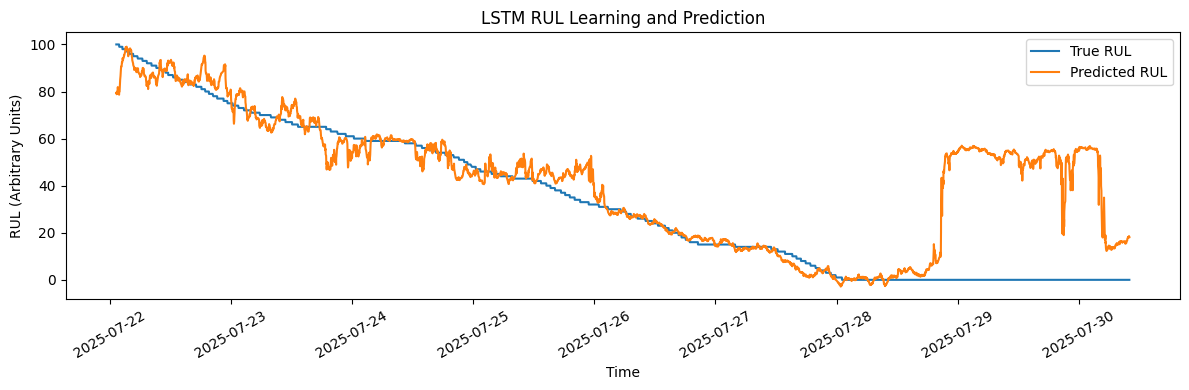

RUL預測 MSE: 464.22, MAE: 11.69


In [50]:
## 利用LSTM學習RUL曲線並預測分析

# 1. 準備RUL資料（以上一cell產生的rul為目標）
from sklearn.preprocessing import MinMaxScaler

# 特徵可用原本的感測數據，也可加入溫度預測值等
X_rul = test_df[['Vibration(mm/s)', 'Current(A)', 'Temperature(°C)']].iloc[seq_length:].values
rul_target = rul.reshape(-1, 1)

# 標準化
scaler_X_rul = MinMaxScaler()
scaler_y_rul = MinMaxScaler()
X_rul_scaled = scaler_X_rul.fit_transform(X_rul)
y_rul_scaled = scaler_y_rul.fit_transform(rul_target)

# 建立序列資料
seq_length_rul = 10
def create_rul_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:(i + seq_length)])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

X_rul_seq, y_rul_seq = create_rul_sequences(X_rul_scaled, y_rul_scaled, seq_length_rul)

# 2. LSTM模型訓練
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_rul = Sequential([
    LSTM(32, input_shape=(X_rul_seq.shape[1], X_rul_seq.shape[2]), return_sequences=False),
    Dense(1)
])
model_rul.compile(optimizer='adam', loss='mse')

history_rul = model_rul.fit(X_rul_seq, y_rul_seq, epochs=30, batch_size=16, validation_split=0.2, verbose=1)

# 3. 預測與還原
pred_rul_scaled = model_rul.predict(X_rul_seq)
pred_rul = scaler_y_rul.inverse_transform(pred_rul_scaled)
true_rul = scaler_y_rul.inverse_transform(y_rul_seq)

# 4. 結果分析與視覺化
plt.figure(figsize=(12, 4))
# 取得對應的時間序列（與y_rul_seq對齊）
rul_time_seq = rul_time.iloc[seq_length_rul:].reset_index(drop=True)
plt.plot(rul_time_seq, true_rul, label='True RUL', color='tab:blue')
plt.plot(rul_time_seq, pred_rul, label='Predicted RUL', color='tab:orange')
plt.title('LSTM RUL Learning and Prediction')
plt.ylabel('RUL (Arbitrary Units)')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_rul = mean_squared_error(true_rul, pred_rul)
mae_rul = mean_absolute_error(true_rul, pred_rul)
print(f"RUL預測 MSE: {mse_rul:.2f}, MAE: {mae_rul:.2f}")



### --- 新增：針對RUL>0區段進行預測的程式碼 ---

88/88 [==============================] - 0s 4ms/step


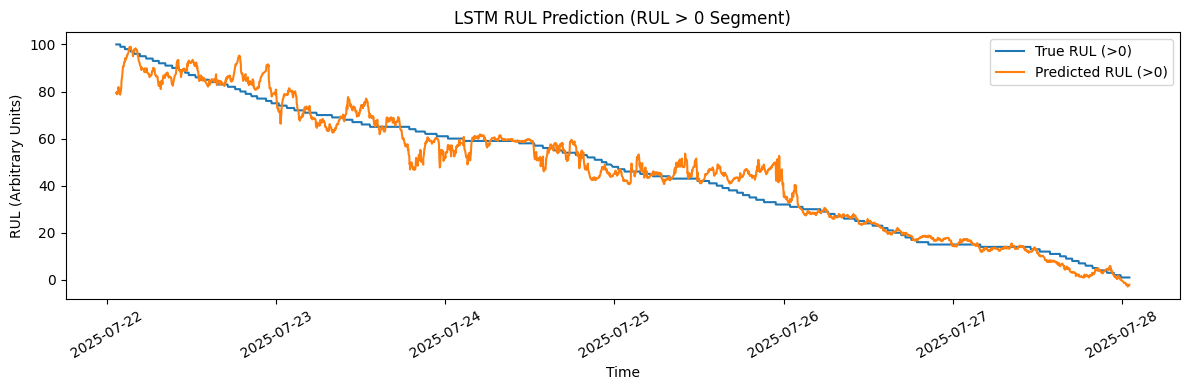

RUL>0區段預測 MSE: 28.27, MAE: 3.72


In [51]:
# 只針對RUL>0區段進行LSTM預測分析

# 確保已有必要的變數
if 'X_rul_seq' not in locals() or 'y_rul_seq' not in locals():
    print("錯誤：請先執行前面的代碼以創建必要的變數")
else:
    # 找出RUL>0的區段索引
    rul_positive_idx = np.where(rul[seq_length_rul:] > 0)[0]

    # 若有RUL>0區段才進行分析
    if len(rul_positive_idx) > 0:
        # 取出RUL>0區段的序列資料
        X_rul_seq_pos = X_rul_seq[rul_positive_idx]
        y_rul_seq_pos = y_rul_seq[rul_positive_idx]
        rul_time_seq_pos = rul_time.iloc[seq_length_rul:].reset_index(drop=True).iloc[rul_positive_idx]

        # LSTM模型訓練（可重新訓練或直接用原模型預測）
        pred_rul_scaled_pos = model_rul.predict(X_rul_seq_pos)
        pred_rul_pos = scaler_y_rul.inverse_transform(pred_rul_scaled_pos)
        true_rul_pos = scaler_y_rul.inverse_transform(y_rul_seq_pos)

        # 結果分析與視覺化
        plt.figure(figsize=(12, 4))
        plt.plot(rul_time_seq_pos, true_rul_pos, label='True RUL (>0)', color='tab:blue')
        plt.plot(rul_time_seq_pos, pred_rul_pos, label='Predicted RUL (>0)', color='tab:orange')
        plt.title('LSTM RUL Prediction (RUL > 0 Segment)')
        plt.ylabel('RUL (Arbitrary Units)')
        plt.xlabel('Time')
        plt.xticks(rotation=30)
        plt.legend()
        plt.tight_layout()
        plt.show()

        mse_rul_pos = mean_squared_error(true_rul_pos, pred_rul_pos)
        mae_rul_pos = mean_absolute_error(true_rul_pos, pred_rul_pos)
        print(f"RUL>0區段預測 MSE: {mse_rul_pos:.2f}, MAE: {mae_rul_pos:.2f}")
    else:
        print("RUL>0區段不存在，無法進行預測分析。")